In [1]:
import os,sys
import re
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import log_loss
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from mochi import CVstatistics,runXGB
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_path = '/data/kaggleData/2sigma/'
model_list=['knn4','knn8','knn16','knn32','xgb142','et1000mf140','lrl2C3','rf1000mf70','nn','lgbm'
           ,'lr4']

## Loading the files

In [33]:
#loading the meta-features generated by the base models
meta_train_temp_list=[]
meta_test_temp_list=[]

for model in model_list:
    dp = os.listdir(data_path+model+'/')
    fold_out_file = []
    for filename in dp:
        if re.match('\S+-5fold-out-\d.pickle',filename)!=None:
            fold_out_file.append(filename)
        elif re.match('\S+-bulk-out.json',filename)!=None:
            bulk_out_file = filename
            
    fold_out_file=sorted(fold_out_file)
    
    pickle_data = []
    json_data = pd.read_json(data_path+model+'/'+bulk_out_file)
    temp_meta_test=pd.DataFrame(json_data['high'])
    temp_meta_test.columns=[model+'_high']
    temp_meta_test[model+'_medium']=json_data['medium']
    temp_meta_test[model+'_low']=json_data['low']
    if 'listing_id' in json_data.columns:
        test_listing=json_data['listing_id']
    
    for pickle_file in fold_out_file:
        pickl_file = data_path+model+'/'+pickle_file
        fileObject = open(pickl_file,'r') 
        pickle_data.append(pd.DataFrame(pickle.load(fileObject)))   
        fileObject.close()
        
    temp_meta_train=pd.concat(pickle_data)
    temp_meta_train.columns=[model+'_high',model+'_medium',model+'_low']
    temp_meta_test.columns=[model+'_high',model+'_medium',model+'_low']
    meta_train_temp_list.append(temp_meta_train)
    meta_test_temp_list.append(temp_meta_test)
    
meta_train=pd.concat(meta_train_temp_list,axis=1)
meta_test=pd.concat(meta_test_temp_list,axis=1)

In [34]:
#loading the labels for meta-training data
y_data = []
for pickle_file in ['y-5fold-out-0.pickle','y-5fold-out-1.pickle','y-5fold-out-2.pickle','y-5fold-out-3.pickle','y-5fold-out-4.pickle']:
    pickl_file = data_path+'/'+pickle_file
    fileObject = open(pickl_file,'r') 
    y_data.append(pd.DataFrame(pickle.load(fileObject)))   
    fileObject.close()
meta_train_y=np.array(pd.concat(y_data)[0])

/opt/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


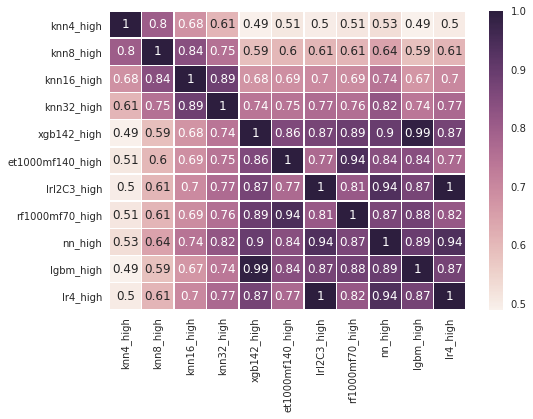

In [37]:
#plotting the correlation of high
highs=meta_train.filter(like='_high')
corr_matrix = highs.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, linewidths=.5)
plt.show()

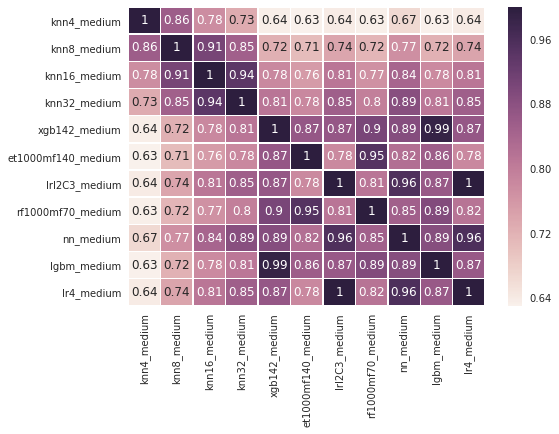

In [39]:
#plotting the correlation of medium
mediums=meta_train.filter(like='_medium')
corr_matrix = mediums.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, linewidths=.5)
plt.show()

In [40]:
meta_features = []
chosen_model = model_list
for feature in meta_train:
    for model in chosen_model:
        if model in feature:
            print model,feature
            meta_features.append(feature)

knn4 knn4_high
nn knn4_high
knn4 knn4_medium
nn knn4_medium
knn4 knn4_low
nn knn4_low
knn8 knn8_high
nn knn8_high
knn8 knn8_medium
nn knn8_medium
knn8 knn8_low
nn knn8_low
knn16 knn16_high
nn knn16_high
knn16 knn16_medium
nn knn16_medium
knn16 knn16_low
nn knn16_low
knn32 knn32_high
nn knn32_high
knn32 knn32_medium
nn knn32_medium
knn32 knn32_low
nn knn32_low
xgb142 xgb142_high
xgb142 xgb142_medium
xgb142 xgb142_low
et1000mf140 et1000mf140_high
et1000mf140 et1000mf140_medium
et1000mf140 et1000mf140_low
lrl2C3 lrl2C3_high
lrl2C3 lrl2C3_medium
lrl2C3 lrl2C3_low
rf1000mf70 rf1000mf70_high
rf1000mf70 rf1000mf70_medium
rf1000mf70 rf1000mf70_low
nn nn_high
nn nn_medium
nn nn_low
lgbm lgbm_high
lgbm lgbm_medium
lgbm lgbm_low
lr4 lr4_high
lr4 lr4_medium
lr4 lr4_low


## 5-fold Cross-Validation for the meta-Learner

In [41]:
KF=StratifiedKFold(5,shuffle=True,random_state = 66666)

In [44]:
meta_features=list(set(meta_features))

In [45]:
cv_scores = []
cv_result = []

i=0        
for dev_index, val_index in KF.split(meta_train,meta_train_y): 
    result_dict = {}

    dev_X, val_X = meta_train[meta_features].iloc[dev_index,:].as_matrix(), meta_train[meta_features].iloc[val_index,:].as_matrix()
    dev_y, val_y = meta_train_y[dev_index], meta_train_y[val_index]
    
    preds,model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=meta_features,
                  early_stop = None,num_rounds = 1200,eta = 0.01,
                  max_depth=3,watch_dict = result_dict,verbose=100,
                  subsample = 0.5,colsample_bytree =0.75)

    loss = log_loss(val_y, preds)
    
    cv_scores.append(loss)
    cv_result.append(result_dict)
    i+=1
    print 'loss for the turn '+str(i)+' is '+str(loss)
    
print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

[0]	train-mlogloss:1.09049	test-mlogloss:1.09049
[100]	train-mlogloss:0.677894	test-mlogloss:0.677449
[200]	train-mlogloss:0.562501	test-mlogloss:0.561655
[300]	train-mlogloss:0.524069	test-mlogloss:0.523414
[400]	train-mlogloss:0.50974	test-mlogloss:0.509761
[500]	train-mlogloss:0.503416	test-mlogloss:0.50451
[600]	train-mlogloss:0.49992	test-mlogloss:0.502309
[700]	train-mlogloss:0.497458	test-mlogloss:0.501298
[800]	train-mlogloss:0.495497	test-mlogloss:0.500899
[900]	train-mlogloss:0.493741	test-mlogloss:0.500763
[1000]	train-mlogloss:0.492073	test-mlogloss:0.500615
[1100]	train-mlogloss:0.490525	test-mlogloss:0.500578
[1199]	train-mlogloss:0.489026	test-mlogloss:0.500604
loss for the turn 1 is 0.500604228083
[0]	train-mlogloss:1.09052	test-mlogloss:1.09051
[100]	train-mlogloss:0.678274	test-mlogloss:0.676569
[200]	train-mlogloss:0.562839	test-mlogloss:0.560424
[300]	train-mlogloss:0.524566	test-mlogloss:0.522059
[400]	train-mlogloss:0.510222	test-mlogloss:0.508074
[500]	train-mlog

In [70]:
print np.std(cv_scores)

0.00686985311159


## 10-fold Cross-validation

In [73]:
KF=StratifiedKFold(10,shuffle=True,random_state = 66666)

In [74]:
cv_scores = []
cv_result = []

i=0        
for dev_index, val_index in KF.split(meta_train,meta_train_y): 
    result_dict = {}

    dev_X, val_X = meta_train[meta_features].iloc[dev_index,:].as_matrix(), meta_train[meta_features].iloc[val_index,:].as_matrix()
    dev_y, val_y = meta_train_y[dev_index], meta_train_y[val_index]
    
    preds,model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=meta_features,
                  early_stop = None,num_rounds = 1200,eta = 0.01,
                  max_depth=3,watch_dict = result_dict,verbose=300,
                  subsample = 0.5,colsample_bytree =0.75)

    loss = log_loss(val_y, preds)
    
    cv_scores.append(loss)
    cv_result.append(result_dict)
    i+=1
    print 'loss for the turn '+str(i)+' is '+str(loss)
    
print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

[0]	train-mlogloss:1.09052	test-mlogloss:1.09047
[300]	train-mlogloss:0.524236	test-mlogloss:0.519087
[600]	train-mlogloss:0.500377	test-mlogloss:0.498395
[900]	train-mlogloss:0.494727	test-mlogloss:0.496878
[1199]	train-mlogloss:0.490416	test-mlogloss:0.496582
loss for the turn 1 is 0.496582433594
[0]	train-mlogloss:1.09052	test-mlogloss:1.09057
[300]	train-mlogloss:0.523395	test-mlogloss:0.527414
[600]	train-mlogloss:0.499494	test-mlogloss:0.506301
[900]	train-mlogloss:0.493679	test-mlogloss:0.504743
[1199]	train-mlogloss:0.489305	test-mlogloss:0.504758
loss for the turn 2 is 0.504758062393
[0]	train-mlogloss:1.09052	test-mlogloss:1.09057
[300]	train-mlogloss:0.523133	test-mlogloss:0.528829
[600]	train-mlogloss:0.499354	test-mlogloss:0.50765
[900]	train-mlogloss:0.493561	test-mlogloss:0.505727
[1199]	train-mlogloss:0.489124	test-mlogloss:0.505355
loss for the turn 3 is 0.505355368961
[0]	train-mlogloss:1.09052	test-mlogloss:1.09046
[300]	train-mlogloss:0.524803	test-mlogloss:0.514636

In [75]:
print np.std(cv_scores)

0.00885943200508


In [84]:
np.arange(0,5,0.5)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])

## Cross validation result plotting

In [76]:
cv_5_fold = ['0.500604228083','0.497726759604','0.499629348987','0.512562721075','0.51382038231']
cv_10_fold = cv_scores

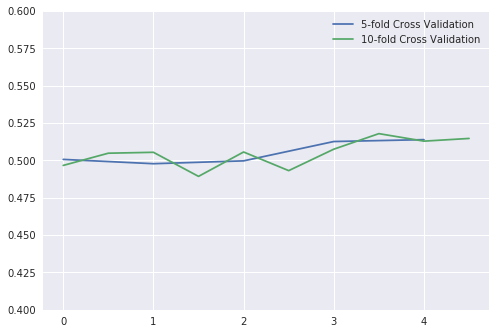

In [90]:
plt.plot(range(5),cv_5_fold,label = '5-fold Cross Validation')
plt.plot(np.arange(0,5,0.5),cv_10_fold,label = '10-fold Cross Validation')
plt.ylim(ymax = 0.6, ymin = 0.4)
plt.legend()
plt.show()

In [91]:
cv_benchmark = pd.read_pickle('benchmark_cross_validation_result.pkl')

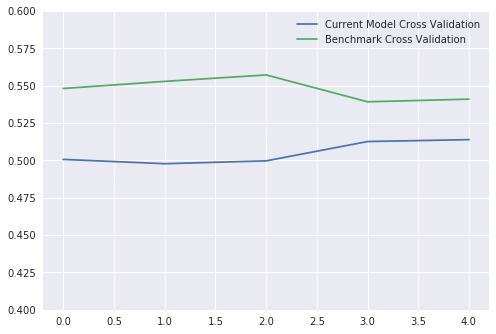

In [92]:
plt.plot(range(5),cv_5_fold,label = 'Current Model Cross Validation')
plt.plot(range(5),cv_benchmark,label = 'Benchmark Cross Validation')
plt.ylim(ymax = 0.6, ymin = 0.4)
plt.legend()
plt.show()

## Generating the result

In [66]:
test_listing =  pd.read_json(data_path+'lgbm/lgbm-bulk-out.json')['listing_id']

In [46]:
train_X, test_X = meta_train[meta_features].as_matrix(), meta_test[meta_features].as_matrix()

preds, model = runXGB(train_X, meta_train_y, test_X,
num_rounds = 1200, eta = 0.01,max_depth = 3,verbose=100
                     ,subsample=0.5,colsample_bytree=0.75)

out_df_expmed = pd.DataFrame(preds)
out_df_expmed.columns = ["high", "medium", "low"]
#out_df.to_json('stack-.json')
out_df_expmed["listing_id"] = test_listing.values

[0]	train-mlogloss:1.09049
[100]	train-mlogloss:0.677378
[200]	train-mlogloss:0.561859
[300]	train-mlogloss:0.523558
[400]	train-mlogloss:0.509373
[500]	train-mlogloss:0.503244
[600]	train-mlogloss:0.500003
[700]	train-mlogloss:0.49781
[800]	train-mlogloss:0.496119
[900]	train-mlogloss:0.494644
[1000]	train-mlogloss:0.493273
[1100]	train-mlogloss:0.491912
[1199]	train-mlogloss:0.490666


In [67]:
out_df_expmed["listing_id"] = test_listing.values

In [69]:
out_df_expmed.to_csv("stack-beta-0.02eta-3mdsb7cb7-project.csv", index=False)